In [ ]:
import cv2

In [ ]:
import os

In [ ]:
import numpy as np
from glob import glob
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

In [ ]:
from keras.optimizers import RMSprop
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the path to the directory containing your JPEG format photos
data_dir = r'/content/drive/MyDrive/Colab Notebooks/fingerprint/fprint'

In [ ]:
data = glob(os.path.join(data_dir, '*.jpg'))

images = []

def read_images(data):
    for i in range(len(data)):
        img = cv2.imread(data[i], cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        images.append(img)
    return images

images = read_images(data)

images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')

In [ ]:
# Rescale pixel values to the range [0, 1]
images_arr = images_arr / 255.0

In [ ]:
# Reshape the data for compatibility with the model
images_arr = images_arr.reshape(-1, 224, 224, 1)

In [ ]:
# Split the data into training and validation sets
train_X, valid_X = train_test_split(images_arr, test_size=0.2, random_state=13)

In [ ]:
# The Convolutional Autoencoder
batch_size = 256
epochs = 300
inChannel = 1
x, y = 224, 224
input_img = Input(shape=(x, y, inChannel))

In [ ]:
def autoencoder(input_img):
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))

autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop())

autoencoder_train = autoencoder.fit(train_X, train_X, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_X))

Epoch 1/300
1/1 [==============================] - 5s 5s/step - loss: 0.1620 - val_loss: 0.1723
Epoch 2/300
1/1 [==============================] - 3s 3s/step - loss: 0.1574 - val_loss: 0.1629
Epoch 3/300
1/1 [==============================] - 3s 3s/step - loss: 0.1488 - val_loss: 0.1449
Epoch 4/300
1/1 [==============================] - 3s 3s/step - loss: 0.1330 - val_loss: 0.1957
Epoch 5/300
1/1 [==============================] - 3s 3s/step - loss: 0.1931 - val_loss: 0.1704
Epoch 6/300
1/1 [==============================] - 3s 3s/step - loss: 0.1569 - val_loss: 0.1447
Epoch 7/300
1/1 [==============================] - 3s 3s/step - loss: 0.1325 - val_loss: 0.1279
Epoch 8/300
1/1 [==============================] - 3s 3s/step - loss: 0.1247 - val_loss: 0.1667
Epoch 9/300
1/1 [==============================] - 3s 3s/step - loss: 0.1630 - val_loss: 0.1563
Epoch 10/300
1/1 [==============================] - 4s 4s/step - loss: 0.1476 - val_loss: 0.1234
Epoch 11/300
1/1 [=====================

In [ ]:
# Save the model weights to an .h5 file
autoencoder.save_weights('autoencoder_weights.h5')


In [ ]:
# Load the saved weights (optional)
# autoencoder.load_weights('autoencoder_weights.h5')

In [ ]:
# Function to reconstruct an image
def reconstruct_image(image):
    # Reshape the image to the model's input shape
    input_image = image.reshape(1, 224, 224, 1)

    # Reconstruct the image using the autoencoder
    reconstructed_image = autoencoder.predict(input_image)

    return reconstructed_image[0, :, :, 0]

In [ ]:
# Load a test image (replace 'test_image.jpg' with the path to your test image)
test_image = cv2.imread(r'/content/drive/MyDrive/Colab Notebooks/fingerprint/fprint/m.jpg')
test_image = cv2.resize(test_image, (224, 224))  # Resize to 224x224
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

In [ ]:
# Reconstruct the test image
reconstructed_test_image = reconstruct_image(test_image)

1/1 [==============================] - 0s 183ms/step


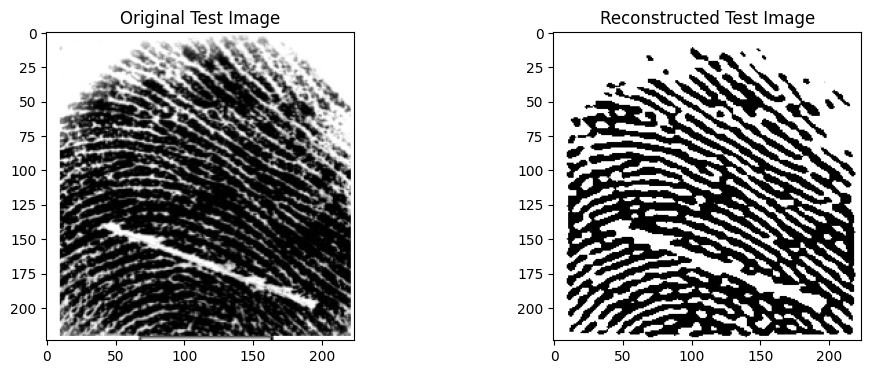

In [ ]:
# Display the original and reconstructed test images
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Test Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_test_image, cmap='gray')
plt.title('Reconstructed Test Image')
plt.show()